<>:476: SyntaxWarning: invalid escape sequence '\d'
<>:524: SyntaxWarning: invalid escape sequence '\o'
<>:476: SyntaxWarning: invalid escape sequence '\d'
<>:524: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6424\1594552304.py:476: SyntaxWarning: invalid escape sequence '\d'
  py.ylabel('$\dot\phi_%i(t)$'%(comp+1))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6424\1594552304.py:524: SyntaxWarning: invalid escape sequence '\o'
  py.ylabel('$\omega_%i(t)$' %(n+1))
INFO:__main__:processed so far: t = 2.0s /40.001s ;
INFO:__main__:Cpt: 
[[ 2.79932297e+01 -3.00113122e-01 -1.00019427e-01  1.21970823e-02]
 [ 1.89954289e+01  2.99903496e-01  6.21146106e-05 -8.91730152e-01]
 [ 1.09972872e+01 -4.61082502e-05  1.00080905e-01  9.04871656e-01]]
INFO:__main__:E: 
[[0.78379599 0.52907616 0.3108648 ]
 [0.52907616 0.35767456 0.20946774]
 [0.3108648  0.20946774 0.12371238]]
INFO:__main__:processed so far: t = 4.0s /40.001s ;
INFO:__main__:Cpt: 
[[ 2.80000379e+

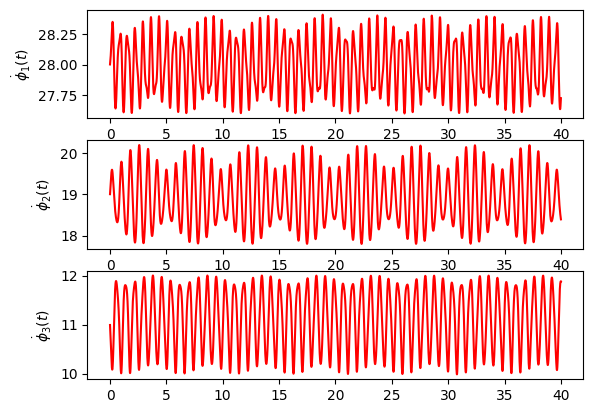

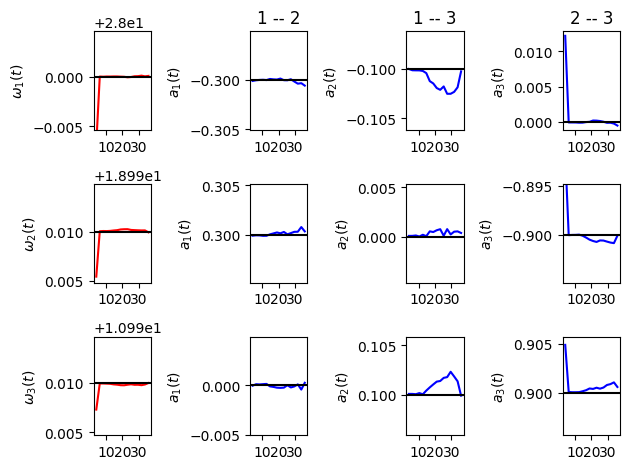

In [1]:
#!/usr/bin/python
# coding: UTF-8
#
# Author: Dawid Laszuk
# Contact: laszukdawid@gmail.com
#
# Feel free to contact for any information.
#
# You can cite this code by referencing:
#   D. Laszuk, "Python implementation of Bayesian inference
#   for Kuramoto systems," 2015-,
#   [Online] Available: http://www.laszukdawid.com/codes
#
# LICENCE:
#  This program is free software; you can redistribute it and/or modify
#  it under the terms of the GNU General Public License as published by
#  the Free Software Foundation; either version 2 of the License, or
#  (at your option) any later version.
#
#  This program is distributed in the hope that it will be useful,
#  but WITHOUT ANY WARRANTY; without even the implied warranty of
#  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#  GNU General Public License for more details.
#
#  You should have received a copy of the GNU General Public License
#  along with this program; if not, write to the Free Software
#  Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston,
#  MA 02110-1301, USA.
#
from __future__ import print_function

import logging
import numpy as np
import pylab as py
from scipy.integrate import ode

class BayesUpdate:
    """
    Class executing dynamical Bayesian inference of time-evolving
    coupled system in presence of noise. Algorithm based on set
    of papers (e.g. see below) and MatLab code provided by one of
    the authors (http://py-biomedical.lancaster.ac.uk/).

    [1] A. Duggento et al., “Dynamical Bayesian inference of
    time-evolving interactions: From a pair of coupled oscillators
    to networks of oscillators,” Phys. Rev. E, 2012.
    [2] Tomislav Stankovski et al., "A tutorial on time-evolving
    dynamical Bayesian inference" Eur. Phys. J. Special Topics 223, 2014.

    """

    logger = logging.getLogger(__name__)

    def __init__(self, M, L):
        """
        Class initiation requires two values:
            M - total number of parameters
            L - number of oscillators.

        Assuming typical correspondance one-to-one between all
        oscillators: M = 1 + L*(L-1)/2 .

        Example of usage:
        B = BayesUpdate(M,L)
        T_out, C_out, E_out = B.runBayes(phi, win, h, ovrPerc, propConst, infoDisplay)

        See self.runBayes for variables explaination.
        """

        self.L = L
        self.M = M
        self.paramK = int(M/L)
        self.Cpr = np.zeros((L, self.paramK))

        self.XIpr = np.matrix(np.zeros((M, M)))
        self.XIpt = np.matrix(np.zeros((M, M)))
        self.E = np.matrix(np.zeros((L, L)))

        # Max iterations
        self.MAX_LOOPS = 100
        self.EPS = 0.0001
    ######################################

    def runBayes(self, ph, win, h, ovrPerc, propConst, **kwargs):
        """
        # The main function.
        # Windows signal, calculte parameter matrices and propagates
        # results to next windows.
        #
        #---inputs---
        # Ph - phase time-series numpy array - 2D (osc x sample_num)
        # win - window in seconds
        # h - sampling step e.g. h=0.01
        # ovrPerc - ratio of no-overlaping of windows;
        #           ovrPerc=1 is no overlap; ovr=0.75 will overlap 1/4.
        # propConst - propagation constant
        # infoDisplay - if True, print progress status

        #---outputs---
        # T_out - array of time vector for plotting
        # C_out - array of inferred mean parameters
        # E_out - array of inferred noise

        """
        infoDisplay = kwargs["infoDisplay"] if "infoDisplay" in kwargs else False

        # Setting class variables
        self.h = h
        win = win/h
        w = ovrPerc*win
        pw = win*h*propConst

        Cpr = self.Cpr
        XIpr = self.XIpr

        # Unwrap phases if given in [0, 2pi) range
        if np.max(ph)<(2*np.pi+0.1):
            ph = np.unwrap(ph, axis=1)

        # Number of windows
        IX = int(np.floor((ph[0].size-win)/w))
        self.logger.debug('IX: ', IX)

        # Output arrays
        E_out = np.zeros((IX, self.L, self.L))
        C_out = np.zeros((IX, self.M))

        #############################
        ## Iterate over each segment
        for i in range(IX):

            # Extracting window
            phi = ph[:, int(i*w):int(i*w+win)]

            #-----bayesian inference for one window------
            [Cpt,XIpt,E] = self.adjustBayesParams(Cpr,XIpr,h, phi)

            #the propagation for the next window
            #~ XIpt, Cpt = self.Propagation_function_XIpt(Cpt,XIpt,pw)
            XIpt, Cpt = self.Propagation_function_Cpt(Cpt,XIpt,pw)

            # Save in output arrays
            E_out[i] = E
            C_out[i] = Cpt.flatten()

            # Assigning a posteriori prob of this iteration
            # to a priori prob for next
            Cpr = Cpt.copy()
            XIpr = XIpt.copy()

            #display progress
            if infoDisplay:
                self.logger.info('processed so far: t = ' + str((i+1)*w*h) + 's /' + str(ph[0].size*h) + 's ;')
                self.logger.info('Cpt: \n' + str(Cpt))
                self.logger.info('E: \n' + str(E))


        # Creat time vector for plotting
        T_out = h*np.linspace(win/2, ph[0].size-win/2, IX)


        return T_out, C_out, E_out

    def adjustBayesParams(self,Cpr,XIpr,h, Phi):
        """
        #infers the parameters and the noise within one block of data.
        #The base functions are only for the EXAMPLE1 with two phase oscillators.

        #---inputs---
        # Cpr - prior vector of parameters
        # XIpr - prior concentration matrix (i.e. inv(covariance) matrix)
        # h - sampling rate (e.g. h=0.01)
        # Phi - input block of data

        # Notation:
        # pr -- a priori
        # pt -- a posteriori

        #---outputs---
        # Cpt - posterior vector of parameters
        # XIpt - poaterior concentration matrix (i.e. inv(covariance) matrix)
        # E - noise matrix
        """

        # phiS - the midpoint time series
        # phiT - the derivative time series
        phiT = np.diff(Phi, axis=-1)/self.h
        phiS = (Phi[:,1:]+Phi[:,:-1])/2

        # Calculate transfer function and its derivatives.
        # Resuts are converted to matrices for easier manipulations.
        P = np.matrix( self.calculateP(phiS) )
        V = np.matrix( self.calculateV(phiS) )

        # Convert to matrices for easier mianpulations.
        phiT = np.matrix(phiT)
        Cpr = np.matrix(Cpr)

        # Initialte
        Cpt = Cpr #initialize Cpt

        # oop to converge iteratively the result until desired precision is reached

        for i in range(self.MAX_LOOPS):

            E = self.calculateE(Cpr, phiT, h, P)
            Cpt,XIpt = self.calculateC(E, P, V, Cpr, XIpr, phiT)

            # If parameters converge
            c1, c2 = np.array(Cpt), np.array(Cpr)
            if(np.sum(np.power((c1-c2)/c1, 2)) < self.EPS):
                break

            #~ Cpr = Cpt.copy()
            #~ XIpr = XIpt.copy()

        return (Cpt, XIpt, E)
    ######################################

    def calculateP(self,phiS):
        """Calculates what is the P vector ( f = c P ).

            Returns V vector of shape (1+d1*(d1-1)/2 , d2).
            d1 - number of oscillators
            d2 - number of data points
        """
        d1, d2 = phiS.shape
        P = np.zeros((self.paramK, d2))

        n = 0
        P[n] = 1
        n += 1
        for i in range(0, d1):
            for j in range(i+1, d1):
                dPhi = phiS[i]-phiS[j]
                P[n] = np.sin(dPhi)
                n += 1

        return P
    ######################################

    def calculateV(self,phiS):
        """ Calculate derivatives of P vector in respect
            to each variable.

            Returns V vector of shape (d1*M , d2).
            d1 - number of oscillators
            d2 - number of data points
            M  - number of parameters
        """
        d1, d2 = phiS.shape
        v = np.zeros((d1*self.M, d2))

        n = 0
        for i in range(0, d1):
            v[n] = 0

            for x in range(0,d1):
                for y in range(x+1, d1):
                    if i == x or i==y:
                        dPhi = phiS[x]-phiS[y]
                        v[n] = np.cos(dPhi)*((-1)**(i==y))
                        n += 1
                    else:
                        v[n] = 0
                        n += 1

        return v
    ######################################

    def calculateE(self,c,phiT,h,p):
        """ Calculates noise matrix.
        """

        # Make sure dimension is correct
        E = np.zeros((self.L, self.L))

        # Update noise matrix
        X = phiT-c*p
        E += X*X.T *h/phiT[0].size

        return E
    ######################################

    def calculateC(self, E, P, V, Cpr, XIpr, phiT):
        """ Calculates parameter vector C.
        """

        paramK = int(self.M/self.L)

        # Initiate vectors
        r = np.zeros(self.M)
        XIpt = np.matrix(np.zeros((self.M, self.M)))

        # Inverse vectors
        invE = np.linalg.inv(E)
        ED = invE*phiT

        pT = P.T
        ppT = P*pT

        # Calculating XI matrix (concentration matrix)
        for xI in range(self.L):
            xIK = int(xI*paramK)
            for yI in range(self.L):
                yIK = int(yI*paramK)

                # Posteriori Xi based on priori Xi and transfer function
                XIpt[xIK:xIK+paramK, yIK:yIK+paramK] = \
                    XIpr[xIK:xIK+paramK, yIK:yIK+paramK] \
                    + self.h*invE[xI,yI]*ppT


        ##############
        # calculating r vector

        for xI in range(self.L):
            xIK = xI*paramK
            _r = np.zeros((1, paramK))
            for yI in range(self.L):
                yIK = yI*paramK
                _r  += Cpr[yI]*XIpr[xIK:xIK+paramK, yIK:yIK+paramK]
                #~ _r  += Cpr[yI]*XIpt[xIK:xIK+paramK, yIK:yIK+paramK]

            # Update r vector
            _r += self.h*(np.dot(P, ED[xI].T) - 0.5*np.sum(V[xIK:xIK+paramK],axis=1)).T
            r[xIK:xIK+paramK] = _r.flatten()
        ##############

        # New parameters are inv(XI) * R
        R = np.matrix(r)
        C = (R*np.linalg.inv(XIpt)).T

        # Reshape to matrix form
        Cpt = C.reshape((self.L, paramK))
        Cpt = np.matrix(Cpt)


        return (Cpt,XIpt)
    ######################################

    def setPriorC(self, C):
        """ Assign value to prior C, if known.
        """
        self.Cpr = C
    ######################################

    def setPriorXi(self, Xi):
        """ Assign value to prior Xi, if known.
        """
        self.XIpr = Xi
    ######################################

    def Propagation_function_XIpt(self,Cpt,XIpt,p):
        """ Propagation function for params covariance
            based on XIpt matrix.
        """

        # Prepare the diffusion matrix
        # Set a value for a particular parameter
        invXIpt = np.linalg.inv(XIpt)

        Inv_Diffusion = np.diag(np.diag(invXIpt))*p*p

        # The gaussian of the posterior is convoluted with another
        # gaussian which express the diffusion of the parameter.
        XIpr= np.linalg.inv( ( invXIpt + Inv_Diffusion ) )

        return XIpr,Cpr
    ######################################

    def Propagation_function_Cpt(self,Cpt,XIpt,p):
        """ Propagation function for params covariance
            based on Cpt matrix.
        """

        # Prepare the diffusion matrix
        # Set a value for a particular parameter
        Inv_Diffusion = np.diag( np.ravel(Cpt) )*p*p
        invXIpt = np.linalg.inv(XIpt)

        # The gaussian of the posterior is convoluted with another
        # gaussian which express the diffusion of the parameter.
        XIpr = np.linalg.inv(( invXIpt + Inv_Diffusion ))

        return XIpr,Cpt
    ######################################

# End of Class

def kuramoto_ODE(t, y, arg=None):
    """Function passed for ODE solver.
       In this case it is frequency Kuramoto model.
    """

    w, k = arg
    n_osc = len(w)

    if len(y)>1:
        coupling = lambda i, j: k[i][j]*np.sin(y[j]-y[i])
        R = lambda i: np.random.normal(0,1)*0.00001
        out = [w[i] + R(i) + np.sum([coupling(i,j) for j in range(n_osc) if i!=j]) for i in range(n_osc)]
        #~ out = [w[i] + np.sum([coupling(i,j) for j in range(n_osc) if i!=j]) for i in range(n_osc)]
    else:
        out = w[0]
    return out
######################################

# Exaple usage of program.
# 1. Prepare oscillators.
# 2. Adjust Kuramoto system via Bayes inference
# 3. Plot results

if __name__ == "__main__":

    logging.basicConfig(level=logging.INFO)
    ####################################################
    # 1. Prepareding oscillators
    t0, t1, dt = 0, 40, 0.001
    N, h = int((t1-t0)/dt), dt

    win = 8 # seconds
    h = dt
    ovrPerc = 0.25 # overlap 1 - percentage
    propConst = 0.04
    infoDisplay = True

    T = np.arange(t0, t1, dt)

    # Y0, W, K are initial phase, intrisic freq and
    # coupling K matrix respectively
    _Y0 = [0, np.pi,0,1, 5, 2, 3]
    _W = [28,19,11,9, 2, 4]
    _K = [[0.0, 0.3, 0.1, 0.1, 0.5, 0.0],
          [0.3, 0.0, 0.9, 0.0, 0.1, 1.0],
          [0.1, 0.9, 0.0, 0.4, 0.0, 0.2],
          [0.1, 0.0, 0.4, 0.0, 1.0, 0.4],
          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    _K = np.array(_K)
    _K = (_K + _K.T)/2

    # Preparing oscillators with Kuramoto model
    oscN = 3 # num of oscillators

    Y0 = _Y0[:oscN]
    W = _W[:oscN]
    K = _K[:oscN,:oscN]

    ####################################################
    # Setting up ODE integrator
    kODE = ode(kuramoto_ODE)
    kODE.set_integrator("vode")

    # Set parameters into model
    kODE.set_initial_value(Y0,t0)
    kODE.set_f_params((W, K))

    # Run ODE integrator
    odeT, odePhi = [], []
    while kODE.successful() and kODE.t < t1:
        kODE.integrate(kODE.t + dt)

        odeT.append( kODE.t )
        odePhi.append( kODE.y )

    # Convert to numpy array
    odePhi = np.array(odePhi).T

    # Plot the phases
    py.figure()

    for comp in range(len(W)):
        py.subplot(len(W),1,comp+1)
        py.plot(odeT[:-1],np.diff(odePhi[comp])/dt,'r')
        py.ylabel('$\dot\phi_%i(t)$'%(comp+1))
    py.savefig('phases')

    ####################################################
    ## 2. Adjust Kuramoto model

    # Performing Bayes calc

    L = len(W) # num of oscillators
    compN = 1  # Fourier components for ech
    M = int(L*(1+0.5*compN*(L-1)*L)) # Number of all parameters

    # Prior C matrix
    priorC = np.zeros((L, int(M/L)))
    #~ priorC[:,0] = np.array(W)

    # Calculate parameters
    B = BayesUpdate(M,L)
    B.setPriorC(priorC)

    config = {"infoDisplay": True}
    T_out, C_out, E_out = B.runBayes(odePhi, win, h, ovrPerc, propConst, **config)


    ####################################################
    ## 3. Plot results

    # Min plotting resolution
    minRes = 0.01
    resolution = lambda S: np.max(S)-np.min(S)

    # Plotting Bayes results

    py.figure()
    colNum = oscN
    nDiffCouplings = int(oscN*(oscN-1)/2)
    rowNum = int(nDiffCouplings+1)

    # Labels for coupling
    coupLabel = ["%i -- %i"%(i+1,j+1) for i in range(oscN) for j in range(i+1,oscN)]
    coupOsc = [(i,j) for i in range(oscN) for j in range(i+1,oscN)]

    # Plot for each oscillator (row)
    for n in range(colNum):

        # Plot estimated intrinsic freq
        py.subplot(colNum,rowNum,rowNum*n+1)
        py.plot(T_out, C_out[:,rowNum*n],'r')
        py.ylabel('$\omega_%i(t)$' %(n+1))

        # Black line - real value
        py.axhline(W[n], color='black')

        # Making sure that plots lookg good
        if resolution(C_out[:,rowNum*n]) < minRes:
            py.ylim((np.mean(C_out[:,rowNum*n])-minRes/2, np.mean(C_out[:,rowNum*n])+minRes/2))

        # Plot coupling factors
        for _k in range(nDiffCouplings):
            py.subplot(colNum,rowNum,rowNum*n+_k+2)
            py.plot(T_out, C_out[:,rowNum*n+_k+1],'b')

            # Making sure that plots lookg good
            if resolution(C_out[:,rowNum*n+_k+1]) < minRes:
                py.ylim((np.mean(C_out[:,rowNum*n+_k+1])-minRes/2, np.mean(C_out[:,rowNum*n+_k+1])+minRes/2))

            py.ylabel('$a_%i(t)$' %(_k+1))
            if n==0: py.title(coupLabel[_k])

            # What should be the coupling
            kVal = 0
            if n in coupOsc[_k]:
                sign = (-1)**(n==coupOsc[_k][0])
                kVal = sign*K[coupOsc[_k][0], coupOsc[_k][1]]

            # Black line - real value
            py.axhline( kVal, color='black')

    # Display plot
    py.tight_layout()
    py.show()

# Aplicando à séries temporais de soja

In [2]:
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
import pandas as pd

# Função para gerar dados sintéticos usando o modelo de Kuramoto
def generate_synthetic_data(t, w, k):
    n_osc = len(w)
    y0 = np.random.rand(n_osc) * 2 * np.pi  # Condições iniciais aleatórias
    y = np.zeros((len(t), n_osc))

    for i in range(len(t)-1):
        dt = t[i+1] - t[i]
        y[i+1] = y[i] + kuramoto_ODE(t[i], y[i], arg=(w, k)) * dt

    return y